In [ ]:
!pip install fiftyone

In [ ]:
!wandb login

In [1]:
import fiftyone as fo
from fiftyone.utils.huggingface import load_from_hub
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
import torchvision.transforms.v2 as transforms
from torch.utils.data import DataLoader
import wandb


import sys
from pathlib import Path

project_root = Path("..").resolve()
sys.path.append(str(project_root))
from src import datasets
from src import training
from src import visualization
from src import models

/home/matthias/miniconda3/envs/CompVision/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load Data

As we did in the previous notebooks we start by loading the data as a fiftyone dataset from huggingface.

In [3]:
IMG_SIZE = 64
BATCH_SIZE = 32

In [4]:
# load fiftyone dataset from huggingface
dataset = load_from_hub(
    "MatthiasCr/multimodal-shapes-subset", 
    name="multimodal-shapes-subset",
    # fewer workers and greater batch size to hopefully avoid getting rate limited
    num_workers=2,
    batch_size=1000,
    overwrite=True,
)

Loading dataset
Importing samples...
 100% |███████████████| 4000/4000 [50.8ms elapsed, 0s remaining, 78.8K samples/s]   


In [5]:
img_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
])

train_dataset = datasets.MultimodalDataset(dataset, "train", img_transforms)
val_dataset = datasets.MultimodalDataset(dataset, "val", img_transforms)

# use generator with fixed seed for reproducible shuffling
generator = torch.Generator()
generator.manual_seed(51)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, generator=generator)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

# number of train batches, needed for learning rate scheduling
steps_per_epoch = len(train_dataloader)

## Baseline Lidar Classifier

We first train a single modal classifier that only uses lidar data to do the cube/sphere classification. This `LidarClassifier` consists of an embedder and a classification head. The purpose of this model is to define an embedding space for lidar data and to have a classifier head that works on these embeddings. We will later project image embeddings onto this lidar embedding space so that we can use this classifier head (without the embedder) for classification of image data.

In [ ]:
lidar_classifier = models.LidarClassifier().to(device)
lidar_classifier_num_params = sum(p.numel() for p in lidar_classifier.parameters())
epochs = 20
start_lr = 1e-4
end_lr = 1e-6

optim = Adam(lidar_classifier.parameters(), lr=start_lr)
scheduler = CosineAnnealingLR(optim, T_max=epochs * steps_per_epoch, eta_min=end_lr)
loss_func = nn.BCEWithLogitsLoss()

In [ ]:
def apply_classifier_model(model, batch):
    # only lidar data used
    _, inputs_xyz, target = batch
    inputs_xyz = inputs_xyz.to(device)
    target = target.to(device)
    outputs = model(raw_data=inputs_xyz)
    return outputs, target

In [ ]:
run = training.initWandbRun(
    "", epochs, BATCH_SIZE, lidar_classifier_num_params, "Adam", "Cosine Annealing", start_lr, end_lr
)

classifier_train_loss, classifier_val_loss = training.train_model(
    lidar_classifier, 
    optim, 
    apply_classifier_model, 
    loss_func, 
    epochs, 
    train_dataloader, 
    val_dataloader, 
    device, 
    run, 
    scheduler=scheduler, 
    output_name="lidar_classifier"
)

run.finish()

visualization.plot_loss(epochs,
    {
        "Classifier Train Loss": classifier_train_loss,
        "Classifier Val Loss": classifier_val_loss
    }
)

Now load the best checkpoint and freeze the model so we can use it later without altering it.

In [ ]:
lidar_classifier = models.LidarClassifier()
lidar_classifier.load_state_dict(
    torch.load("../checkpoints/lidar_classifier.pt", map_location=device))
lidar_classifier = lidar_classifier.to(device)

for param in lidar_classifier.parameters():
    param.requires_grad = False
lidar_classifier.eval()

## CILP Model

In [15]:
BATCH_SIZE = 32
cilp_model = models.ContrastivePretraining(batch_size=BATCH_SIZE).to(device)
cilp_num_params = sum(p.numel() for p in cilp_model.parameters())
epochs = 20
lr = 1e-2


optim = Adam(cilp_model.parameters(), lr=lr)

In [16]:
def apply_cilp_model(model, batch):
    # cilp model doesn't use the class information
    inputs_rgb, inputs_xyz, _ = batch
    inputs_rgb = inputs_rgb.to(device)
    inputs_xyz = inputs_xyz.to(device)
    logits_per_img, logits_per_lidar = model(inputs_rgb, inputs_xyz)
    return logits_per_img, logits_per_lidar

loss_img = nn.CrossEntropyLoss()
loss_lidar = nn.CrossEntropyLoss()
ground_truth = torch.arange(BATCH_SIZE, dtype=torch.long).to(device)

def cilp_loss(logits_per_img, logits_per_lidar):
    return (loss_img(logits_per_img, ground_truth) + loss_lidar(logits_per_lidar, ground_truth)) / 2

All random seeds set to 51 for reproducibility
epoch 0 train loss: 3.4519930696487426
epoch 0 valid loss: 3.4516155322392783
Found and saved better weights for the model
epoch 1 train loss: 3.0775979137420655
epoch 1 valid loss: 2.755907893180847
Found and saved better weights for the model
epoch 2 train loss: 2.7227703380584716
epoch 2 valid loss: 2.690623621145884
Found and saved better weights for the model
epoch 3 train loss: 2.6976202058792116
epoch 3 valid loss: 2.6865432461102805
Found and saved better weights for the model
epoch 4 train loss: 2.692570185661316
epoch 4 valid loss: 2.681710362434387
Found and saved better weights for the model
epoch 5 train loss: 2.689855623245239
epoch 5 valid loss: 2.6751750707626343
Found and saved better weights for the model
epoch 6 train loss: 2.6817119216918943
epoch 6 valid loss: 2.670015354951223
Found and saved better weights for the model
epoch 7 train loss: 2.6619997024536133
epoch 7 valid loss: 2.6417428255081177
Found and saved bett

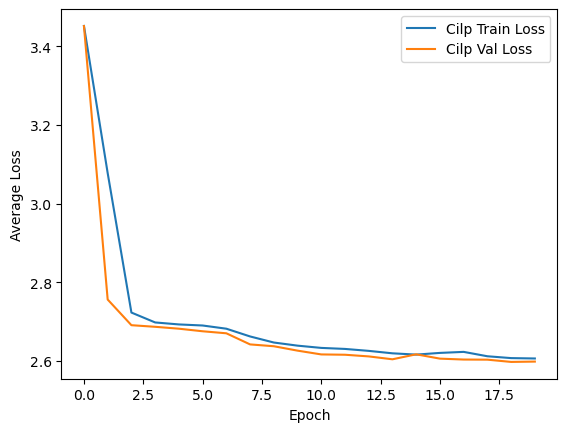

train_loss,█▅▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
total_train_time_sec,210.25297
train_loss,2.60594


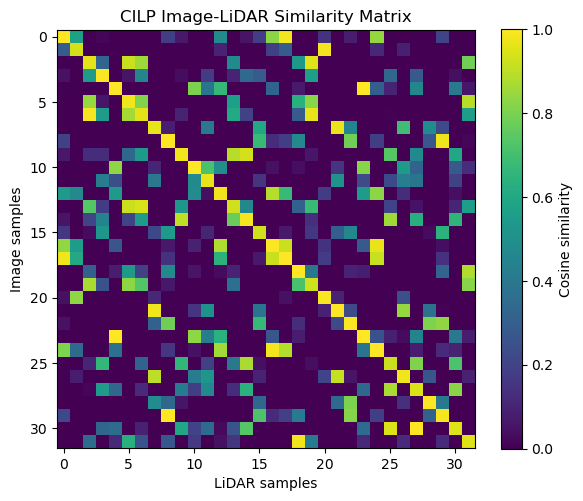

In [ ]:
run = training.initWandbRun(
    "", epochs, BATCH_SIZE, cilp_num_params, "Adam", "", lr, lr
)

cilp_train_loss, cilp_val_loss = training.train_model(
    cilp_model, 
    optim,
    apply_cilp_model, 
    cilp_loss, 
    epochs, 
    train_dataloader, 
    val_dataloader, 
    device, 
    run, 
    scheduler=None, 
    output_name="cilp", 
    calc_accuracy=False
)

visualization.plot_loss(epochs,
    {
        "Cilp Train Loss": cilp_train_loss,
        "Cilp Val Loss": cilp_val_loss
    }
)

visualization.plot_similarity_matrix(cilp_model, apply_cilp_model, val_dataloader, device, run)

run.finish()

Now load the best cilp checkpoint and freeze the model for further usage.

In [ ]:
cilp_model = models.ContrastivePretraining(batch_size=BATCH_SIZE)
cilp_model.load_state_dict(torch.load("../checkpoints/cilp.pt", map_location=device))
cilp_model = cilp_model.to(device)

for param in cilp_model.parameters():
    param.requires_grad = False
cilp_model.eval()

## Projector Model

In [ ]:
source_embedding_dim = cilp_model.get_embedding_size()
target_embedding_dim = lidar_classifier.get_embedding_size()

projector = models.Projector(source_embedding_dim, target_embedding_dim)
projector_num_params = sum(p.numel() for p in projector.parameters())
epochs = 40
lr = 1e-3
optim = torch.optim.Adam(projector.parameters(), lr=lr)

In [ ]:
def apply_projector_model(model, batch):
    rgb_img, lidar_xyz, _ = batch
    rgb_img = rgb_img.to(device)
    lidar_xyz = lidar_xyz.to(device)
    imb_embs = cilp_model.img_embedder(rgb_img)
    lidar_embs = lidar_classifier.get_embs(lidar_xyz)
    pred_lidar_embs = model(imb_embs)
    return pred_lidar_embs, lidar_embs

def projector_loss(pred_lidar_embs, lidar_embs):
    return nn.MSELoss()(pred_lidar_embs, lidar_embs)

# def projector_loss(pred_lidar_embs, lidar_embs):
#     mse = nn.MSELoss()(pred_lidar_embs, lidar_embs)
#     cos = 1 - F.cosine_similarity(pred_lidar_embs, lidar_embs, dim=1).mean()
#     return mse + 1.5 * cos


In [ ]:
run = training.initWandbRun(
    "", epochs, BATCH_SIZE, projector_num_params, "Adam", "", lr, lr
)

projector_train_loss, projector_val_loss = training.train_model(
    projector, 
    optim,
    apply_projector_model, 
    projector_loss, 
    epochs, 
    train_dataloader, 
    val_dataloader, 
    device, 
    run, 
    scheduler=None, 
    output_name="projector", 
    calc_accuracy=False
)

run.finish()

visualization.plot_loss(epochs,
    {
        "Projector Train Loss": projector_train_loss,
        "Projector Val Loss": projector_val_loss
    }
)

Again, load the best saved weights for the projector model. This time we don't freeze it as we fine tune it inside the final RGB-to-Lidar classifier.

In [ ]:
projector = models.Projector(source_embedding_dim, target_embedding_dim)
projector.load_state_dict(torch.load("../checkpoints/projector.pt", map_location=device))
projector = projector.to(device)

## Final RGB-to-Lidar Classifier

In [ ]:
rgbToLiderClassifier = models.RGB2LiDARClassifier(projector, cilp_model, lidar_classifier)
rgbToLidar_num_params = sum(p.numel() for p in rgbToLiderClassifier.parameters())

epochs = 30
start_lr = 1e-2
end_lr = 1e-6
optim = torch.optim.Adam(rgbToLiderClassifier.parameters(), lr=lr)
scheduler = CosineAnnealingLR(optim, T_max=epochs * steps_per_epoch, eta_min=end_lr)

In [ ]:
def apply_rgb_Lidar_Classifier_model(model, batch):
    inputs_rgb, _, target = batch
    inputs_rgb = inputs_rgb.to(device)
    target = target.to(device)
    outputs = model(inputs_rgb)
    return outputs, target

loss_func = nn.BCEWithLogitsLoss()

In [ ]:
run = training.initWandbRun(
    "", epochs, BATCH_SIZE, rgbToLidar_num_params, "Adam", "", lr, lr
)

final_train_loss, final_val_loss = training.train_model(
    rgbToLiderClassifier, 
    optim,
    apply_rgb_Lidar_Classifier_model, 
    loss_func, 
    epochs, 
    train_dataloader, 
    val_dataloader, 
    device, 
    run, 
    scheduler=scheduler, 
    output_name="rgb_to_lidar_classifier"
)

run.finish()

visualization.plot_loss(epochs,
    {
        "Rgb-to-Lidar Train Loss": final_train_loss,
        "Rgb-to-Lidar Val Loss": final_val_loss
    }
)

In [ ]:
rgbToLiderClassifier.eval()
with torch.no_grad():
    batch = next(iter(val_dataloader))
    rgb, lidar_xyza, labels = batch
    rgb = rgb.to(device); lidar_xyza = lidar_xyza.to(device); labels = labels.to(device)

    # True LiDAR path
    true_embs = lidar_classifier.get_embs(lidar_xyza)
    logits_true = lidar_classifier(data_embs=true_embs).squeeze(1)
    acc_true = ((torch.sigmoid(logits_true) >= 0.5) == labels.bool()).float().mean()

    # Projected path
    img_embs = cilp_model.img_embedder(rgb)
    proj_embs = projector(img_embs)
    logits_proj = lidar_classifier(data_embs=proj_embs).squeeze(1)
    acc_proj = ((torch.sigmoid(logits_proj) >= 0.5) == labels.bool()).float().mean()

    # Alignment stats
    cosine = torch.nn.functional.cosine_similarity(proj_embs, true_embs, dim=1).mean()
    norm_true = true_embs.norm(dim=1).mean()
    norm_proj = proj_embs.norm(dim=1).mean()

print(f"Acc true: {acc_true:.3f} | Acc proj: {acc_proj:.3f}")
print(f"Cosine mean: {cosine:.3f} | Norm true: {norm_true:.3f} | Norm proj: {norm_proj:.3f}")
